In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_pow_cols, geo_log_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, train_test_validation
path = "SL_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

# Load Files

In [2]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_SL_SC_path, dtype=dtype).sample(frac=0.05, random_state=1)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [3]:
len(windmill)

48

In [4]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [5]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [6]:
df = features.parallelize_extract(df)

NameError: name 'get_ws_hub_r_u' is not defined

In [ ]:
df.to_parquet("./traintestdata/SL_SC.parquet", index=False)

In [ ]:
# df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
# df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [9]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [10]:
df['VAERDI'] = df['VAERDI'] / df['max_VAERDI'] 
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [11]:
cols = [x for x in df.columns if x not in cols_filter]
df = df.copy()
df[cols] = tools.normalize_zcenter(df[cols])
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [12]:
df_train.to_parquet(constant.SL_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.SL_SC_EVL_path, index=False)

# Neural Network Train

In [13]:
df_train = pd.read_parquet(constant.SL_SC_TRAIN_path)

In [14]:
len(df_train)

445587

In [15]:
df_train.columns

Index(['GSRN', 'Turbine_type', 'Parent_GSRN', 'BBR_municipal', 'Placement',
       'UTM_x', 'UTM_y', 'Capacity_kw', 'Rotor_diameter', 'Navhub_height',
       'In_service', 'grid', 'Aspect', 'Slope', 'Elevation', 'Roughness',
       'max_VAERDI', 'VAERDI', 'TIME_CET', 'wu10', 'wv10', 'wu100', 'wv100',
       'tmp2', 'tmp100', 'wsr_u', 'wsr_v', 'hws_u_wsr', 'hws_v_wsr',
       'hws_uv_wsr', 'hws_uv_wsr^2', 'hws_uv_wsr^3', 'hws_u_rn', 'hws_v_rn',
       'hws_uv_rn', 'hws_uv_rn^2', 'hws_uv_rn^3', 'htmp_inp', 'month', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'hour', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9',
       'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19',
       'h20', 'h21', 'h22', 'h23'],
      dtype='object')

In [16]:
target = ["VAERDI"]
# n_groups=10
# lr=0.001
# num_epochs=50
# hidden_size = 1000

## Original Features


In [17]:
lr=0.001
num_epochs=20
hidden_size = 1000

In [18]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Validation

In [19]:
# train_hists, test_hists = train_test_validation(df=df_train, features=org_cols, model=model_original, lr=lr, num_epochs=num_epochs)

In [20]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [21]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [22]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"original_model.pth")

Epoch 0 train loss: 0.051328789442777634
Epoch 10 train loss: 0.017990728840231895


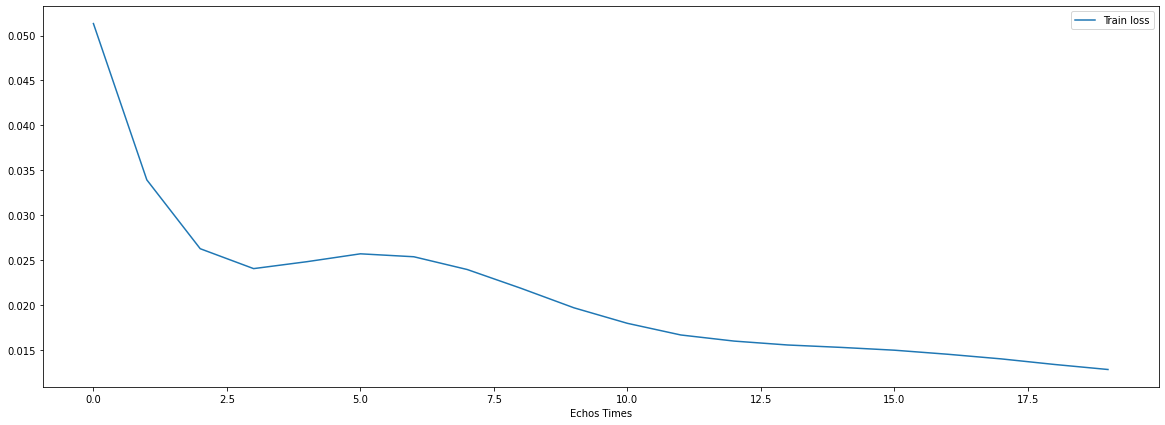

In [23]:
myplot.model_loss({"Train loss":train_hist_original}, path=plot_path+"original_loss.png")

## Windshear Features

In [24]:
lr=0.001
num_epochs=20
hidden_size = 700

In [25]:
model_wsr = MLP_Regression(
  input_size=44,
  hidden_size=hidden_size
)

In [26]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

In [27]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [28]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [29]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"wsr_model.pth")

Epoch 0 train loss: 0.06691507995128632
Epoch 10 train loss: 0.01895197480916977


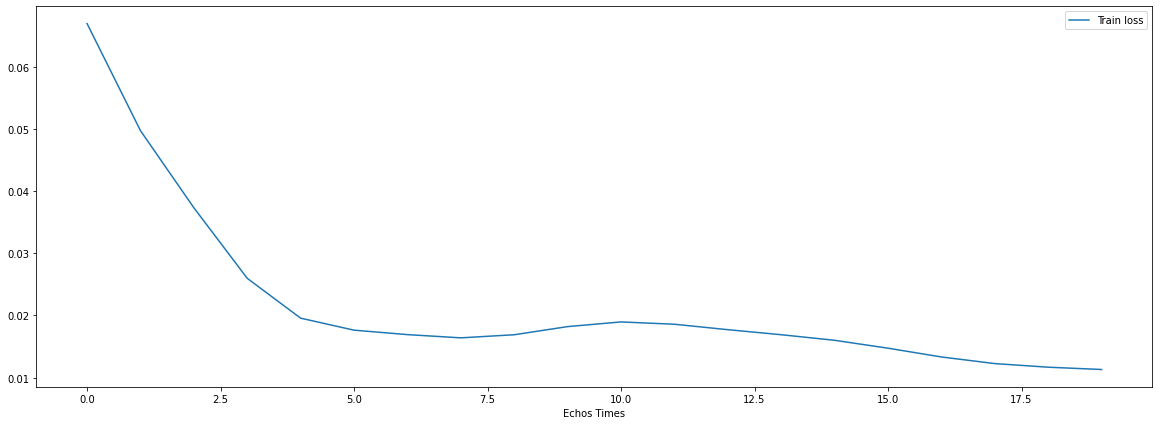

In [30]:
myplot.model_loss({"Train loss":train_hist_wsr}, path=plot_path+"wsr_loss.png")

## Geo Features

In [31]:
lr=0.001
num_epochs=20
hidden_size = 700

In [32]:
model_geo = MLP_Regression(
  input_size=46,
  hidden_size=hidden_size
)

In [33]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

In [34]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [35]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [36]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.07306060194969177
Epoch 10 train loss: 0.01792844757437706


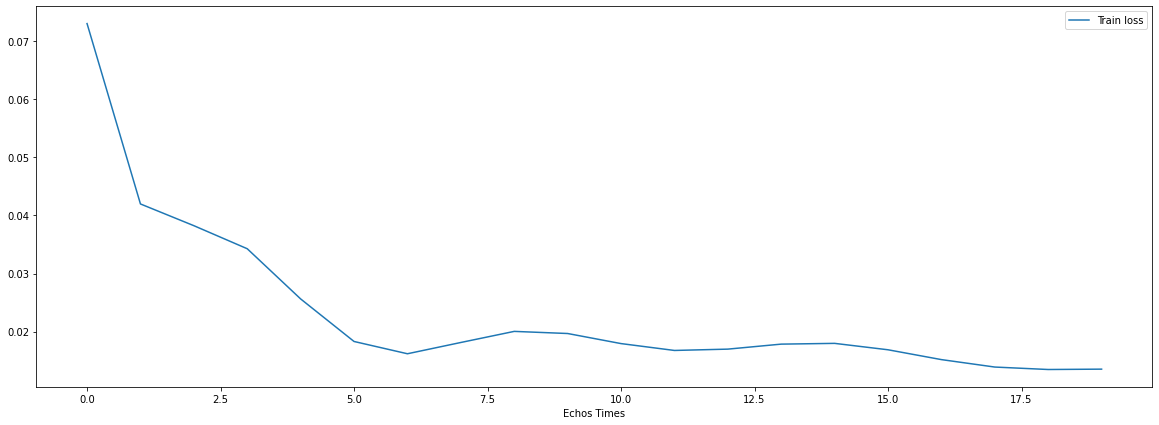

In [37]:
myplot.model_loss({"Train loss":train_hist_geo}, path=plot_path+"geo_loss.png")
# myplot.model_loss({"Train loss":train_hist_geo})

# Semigeo

In [38]:
lr=0.001
num_epochs=20
hidden_size = 700

In [39]:
model_semigeo = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [40]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

In [41]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [42]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [43]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.04890971630811691
Epoch 10 train loss: 0.0168004110455513


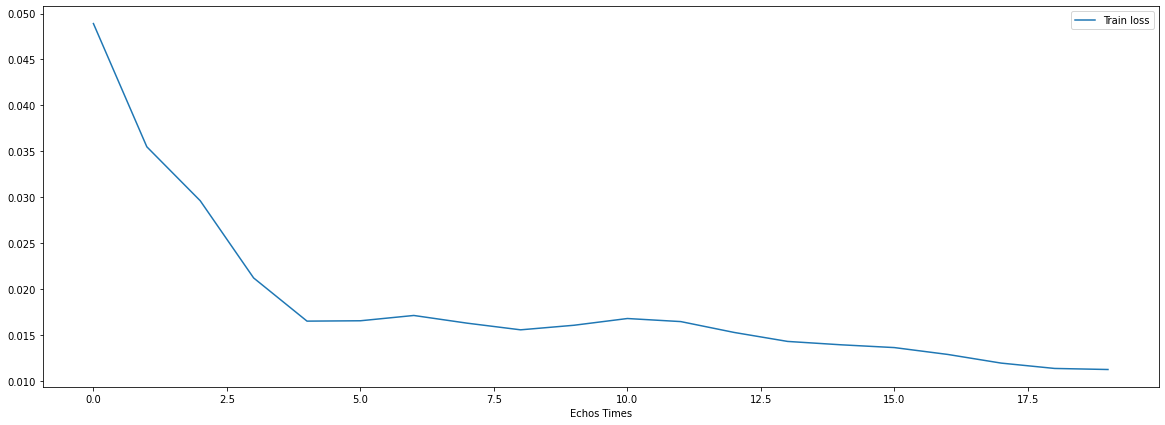

In [44]:
myplot.model_loss({"Train loss":train_hist_semigeo}, path=plot_path+"semigeo_loss.png")